In [2]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyDOE import lhs
#%matplotlib notebook

In [3]:
# define a model
def simple_model(x, y, z):
    return np.sin(x) * y * y    

In [4]:
# define a couple of sampling methods
def full_cubic_sampling(num_vars, bounds, spacing):
    '''Return a set of sampling points.'''
    coordinates = []
    for i in range(num_vars):
        bound = bounds[i]
        coordinates.append(np.arange(bound[0], bound[1], spacing))
    coordinates = coordinates
    sampling = np.array(list(it.product(*coordinates)))
    return sampling

def random_sampling(num_vars, bounds, num_samples):
    '''Return random sampling'''
    sampling = np.random.rand(num_samples, num_vars)
    bounds = np.array(bounds)
    interval = bounds[:,1] - bounds[:,0]
    sampling *= interval
    sampling += bounds[:,0]
    return sampling

# Create samplings
# get full cubic sampling
num_vars = 3
bounds =  [[-2, 2],[-2, 2], [-2, 2]]
spacing = 0.5

fcs = full_cubic_sampling(num_vars, bounds, spacing)

# get random sampling
num_vars = 3
bounds =  [[-2, 2],[-2, 2], [-2, 2]]
num_samples = 1000

rs = random_sampling(num_vars ,bounds, num_samples)

# get a Latin hypercube sampling
n = 3
samples = 1000
lhd = lhs(n=n, samples=samples)
shift = [-2, -2, -2]
scale = [4, 4, 4]
for i in range(n):
    lhd[:, i] = scale[i]*lhd[:, i] + shift[i]

In [5]:
# sample the model
f_fcs = simple_model(*np.transpose(fcs))
f_rs = simple_model(*np.transpose(rs))
f_lhd = simple_model(*np.transpose(lhd))

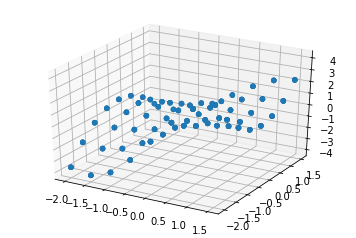

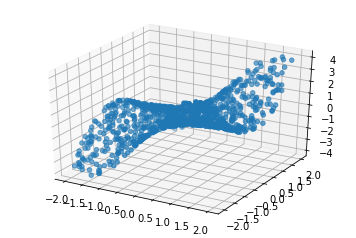

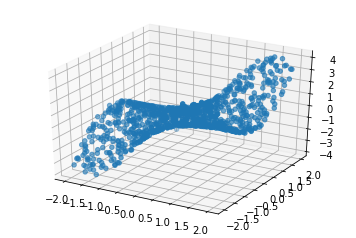

In [6]:
def plot_3D(x, y, z):
    '''Creates a 3D scatter plot.'''
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z)
    plt.show()

# plot the results in 3D
plot_3D(fcs[:,0], fcs[:,1], f_fcs)
plot_3D(rs[:,0], rs[:,1], f_rs)
plot_3D(lhd[:,0], lhd[:,1], f_lhd)

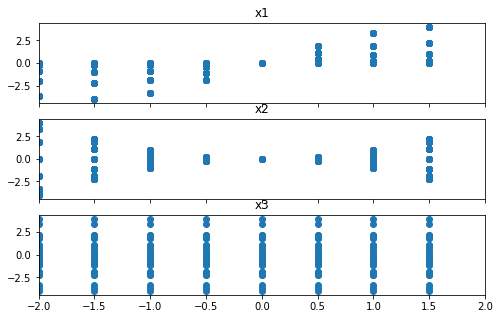

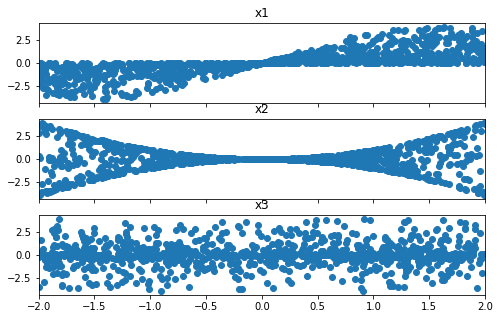

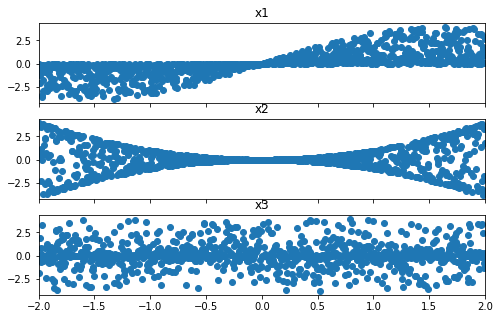

In [7]:
def multiplot_coordinates(num_vars, bounds, titles, sampling, f_sampled):
    %matplotlib inline
    fig, axes = plt.subplots(num_vars, 1, sharex=True, figsize=(8,5))
    for i in range(len(axes)):
        ax = axes[i]
        ax.scatter(sampling[:,i],f_sampled)
        ax.set_title(titles[i])
        ax.set_xlim([-2,2])
    plt.show()

titles = ['x1', 'x2', 'x3']
multiplot_coordinates(num_vars=3, bounds=bounds, titles=titles, sampling=fcs, f_sampled=f_fcs)
multiplot_coordinates(num_vars=3, bounds=bounds, titles=titles, sampling=rs, f_sampled=f_rs)
multiplot_coordinates(num_vars=3, bounds=bounds, titles=titles, sampling=lhd, f_sampled=f_lhd)

### next steps:
* calculate sobol indices
* Fourier amplitude sensitivity test
* Morris
* use it on more complex model

SALib: https://www.theoj.org/joss-papers/joss.00097/10.21105.joss.00097.pdf
https://salib.readthedocs.io/en/latest/
http://www.perrygeo.com/sensitivity-analysis-in-python.html
https://github.com/quaquel/EMAworkbench

In [8]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

problem = {
  'num_vars': 3,
  'names': ['x', 'y', 'z'],
  'bounds': [[-2, 2]]*3
}

# Generate samples
param_values = saltelli.sample(problem, 1000)
print(param_values.shape)

# Run model (example)
Y = simple_model(param_values[:,0], param_values[:,1], param_values[:,2])

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True)
# Returns a dictionary with keys 'S1', 'S1_conf', 'ST', and 'ST_conf'
# (first and total-order indices with bootstrap confidence intervals)

(8000, 3)
Parameter S1 S1_conf ST ST_conf
x 0.553462 0.074093 1.004672 0.126040
y -0.007067 0.074417 0.445774 0.041634
z 0.000000 0.000000 0.000000 0.000000

Parameter_1 Parameter_2 S2 S2_conf
x y 0.448362 0.119440
x z -0.003837 0.052684
y z 0.003848 0.118621


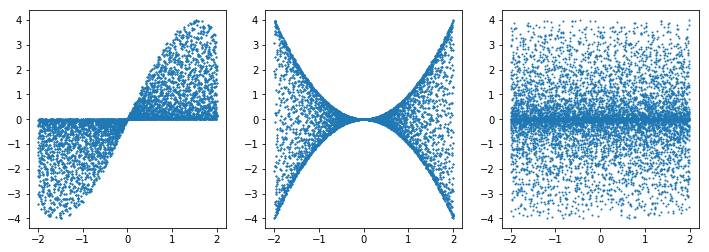

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
for i in [0,1,2]:
    ax[i].scatter(param_values[:,i], Y, s=1)

(10000, 4)
Parameter S1 S1_conf ST ST_conf
x_1 0.642252 0.065189 0.642318 0.053000
x_2 0.288006 0.043181 0.287207 0.025743
x_3 0.071694 0.020711 0.071740 0.005706
x_4 0.000000 0.000000 0.000000 0.000000

Parameter_1 Parameter_2 S2 S2_conf
x_1 x_2 -0.000070 0.099370
x_1 x_3 0.000942 0.086637
x_1 x_4 0.000740 0.083282
x_2 x_3 -0.000788 0.063832
x_2 x_4 0.002518 0.059353
x_3 x_4 0.003197 0.029381


Text(0.5,1,'ST')

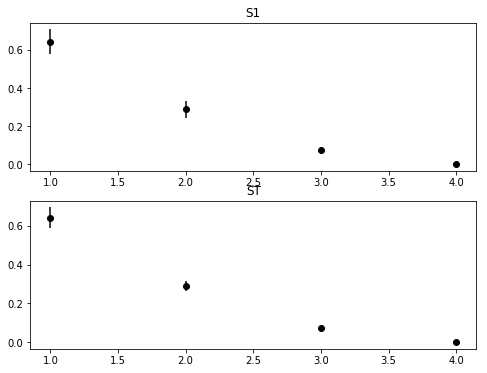

In [11]:
# another model following
# [1]P. Prikhodko and N. Kotlyarov, “Calibration of Sobol indices estimates in case of noisy output,” arXiv:1804.00766 [stat], Apr. 2018.


def linear_model(x_1, x_2, x_3, x_4):
    return 3*x_1 + 2*x_2 + x_3

problem = {
  'num_vars': 4,
  'names': ['x_1', 'x_2', 'x_3', 'x_4'],
  'bounds': [[-20, 6]]*4
}

# Generate samples
param_values = saltelli.sample(problem, 1000)
print(param_values.shape)

# Run model (example)
Y = linear_model(param_values[:,0], param_values[:,1], param_values[:,2], param_values[:,3])

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True)
# Returns a dictionary with keys 'S1', 'S1_conf', 'ST', and 'ST_conf'
# (first and total-order indices with bootstrap confidence intervals)
    
fig, ax = plt.subplots(2, 1, figsize=(8,6))
ax[0].errorbar(x=[1,2,3,4],y=Si['S1'], yerr=Si['S1_conf'], fmt = 'o', color = 'k')
ax[0].set_title('S1')
ax[1].errorbar(x=[1,2,3,4],y=Si['ST'], yerr=Si['ST_conf'], fmt = 'o', color = 'k')
ax[1].set_title('ST')

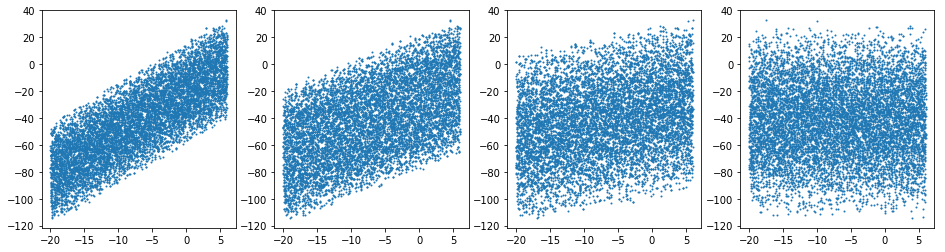

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(16,4))
for i in [0,1,2,3]:
    ax[i].scatter(param_values[:,i], Y, s=1)

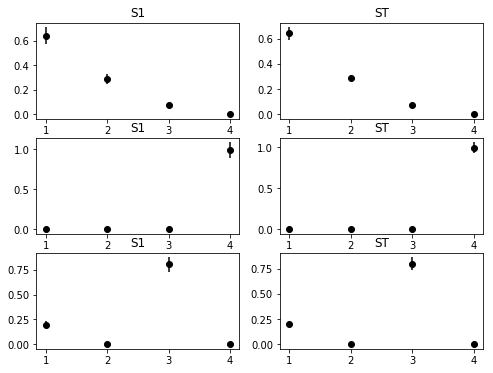

In [13]:
# we can imagine a situation where there are several output variables
def model(x_1, x_2, x_3, x_4):
    y = []
    y.append(3*x_1 + 2*x_2 + x_3)
    y.append(x_1**2 + x_2 - x_3 + x_4**3)
    y.append(x_1 - 2*x_3)
    return y

problem = {
  'num_vars': 4,
  'names': ['x_1', 'x_2', 'x_3', 'x_4'],
  'bounds': [[-20, 6]]*4
}

# Generate samples
param_values = saltelli.sample(problem, 1000)

# Run model (example)
Y = model(param_values[:,0], param_values[:,1], param_values[:,2], param_values[:,3])

# Perform analysis
Si = []
for i in [0,1,2]:
    Si.append(sobol.analyze(problem, Y[i], print_to_console=False))
    # Returns a dictionary with keys 'S1', 'S1_conf', 'ST', and 'ST_conf'
    # (first and total-order indices with bootstrap confidence intervals)

fig, ax = plt.subplots(3, 2, figsize=(8,6))
for i in [0,1,2]:
    ax[i,0].errorbar(x=[1,2,3,4],y=Si[i]['S1'], yerr=Si[i]['S1_conf'], fmt = 'o', color = 'k')
    ax[i,0].set_title('S1')
    ax[i,1].errorbar(x=[1,2,3,4],y=Si[i]['ST'], yerr=Si[i]['ST_conf'], fmt = 'o', color = 'k')
    ax[i,1].set_title('ST')

           0           1          2  name
0 -84.351562  179.254361  -1.251953  test
1 -79.628906  136.750455   0.322266  test
2 -42.203125  200.328580  -1.251953  test
3 -96.640625  191.543424  23.326172  test
4 -84.351562  231.930780  -1.251953  test


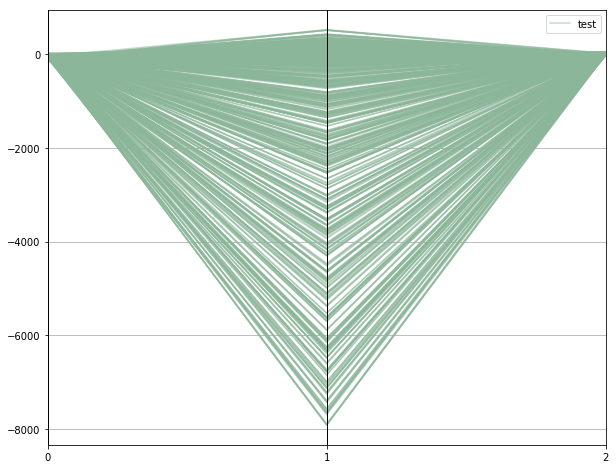

In [18]:
# in this case, we could also plot a parallel coordinates plot
import pandas as pd
fig, ax = plt.subplots(figsize=(10,8))
df = pd.DataFrame(Y).T
df['name'] = 'test'
print(df.head())
pd.plotting.parallel_coordinates(df.head(100), 'name', alpha=.5)

# Other methods, following Pianosi et al. 2016
# Perturbation and derivatives
* Pair comparison of time series or spatial patterns
* Partial derivatives

$S_i(x_0) = \frac{\partial f}{\partial x_i} \bigg\rvert_{x_0} c_i$

Where $c_i$ is a rescaling factor (Hill Tiedemann 2007)

or finite differences, requires num_vars + 1 evaluations.
Details in Norton2015

# Multiple starts perturbation methods

Suitable for screening and ranking  
Rationale: Evaluate local sensitivity at several points in parameter space and get a measure by combining them. The approaches are different by 1) how they combine multiple local measures and 2) how they sample parameter space

* Method of Morris1991 or Elementary effect test (EET) takes the mean of r finite differences. It is also common to calculate standard deviations.

* Saltelli et al propose to take the absolute value before the mean

* Borgonovo introduces a technique that allows to see if sensitivity adds from factors independently or is dominated by interactions.

Sampling stategies

* Morris1991 builds r trajectories through parameter space with random start
  * variant: get random starting points from latin hypercube sampling Campolongo2007
  * variant: create large number of trajectories and select a subset that maximises the spread over space
* radial based design

other approaches

* squared finite differences
* Distributed Evaluation of Local Sensitivity Analysis (DELSA): squared finite differences, plot the full distribution

In [9]:
# Morris1991
import SALib.sample.morris as sam_morris
import SALib.analyze.morris as ana_morris

problem = {
  'num_vars': 3,
  'names': ['x1', 'x2', 'x3'],
  'bounds': [[-2, 2]]*3
}

x = sam_morris.sample(problem, 3, num_levels=4, grid_jump=2)
y = simple_model(*np.transpose(x))
ana_morris.analyze(problem, x, y, conf_level=0.95, print_to_console=True, num_levels=4, grid_jump=2)

Parameter                         Mu_Star         Mu    Mu_Star_Conf      Sigma
x1                                  3.734      3.734           4.377      4.704
x2                                  3.298      1.099           0.000      3.808
x3                                  0.000      0.000           0.000      0.000


{'mu': array([3.73429767, 1.09932409, 0.        ]),
 'mu_star': array([3.73429767, 3.29797228, 0.        ]),
 'mu_star_conf': [4.377401709819931, 1.4571846365263167e-16, 0.0],
 'names': ['x1', 'x2', 'x3'],
 'sigma': array([4.70399513, 3.80817037, 0.        ])}

# Correlation and regression analysis methods
# Regional sensitivity analysis (or Monte Carlo filter)
# Variance-based methods
# Density-based methods